<a href="https://colab.research.google.com/github/WilliamJWen/Project42/blob/main/colab_notebooks/alternate_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project42: AI generated Image Detector**



# Data Preprocessing

In [ ]:
# mount our Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


/


test/  train/  val/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Define data transformations (aligned with your dataset preprocessing)
data_transforms = transforms.Compose([
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


# Define dataset and dataloaders (aligned with your dataset structure)
def get_data_loaders(data_dir, batch_size=64):
    """
    Load datasets from the specified directory, simialr to the collab notebook
    Assuming the directory structure: - I'm confused about this, saw the collab notebook but got more confused
    data_dir/
        train/
            class1/
            class2/
        val/
            class1/
            class2/
        test/
            class1/
            class2/
    """
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')

    train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms)
    test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)

    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
        'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
        'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    }
    return dataloaders

# Initialize model (aligned with your baseline and primary architecture)
def initialize_model(use_pretrained=True):
    """
    Initialize a ResNet18 model with a custom classifier head- similar to the one used in tutorial 3b
    """
    # Load pre-trained ResNet18 (similar to AlexNet in the tutorial)
    model = models.resnet18(pretrained=use_pretrained)

    # Freeze all parameters except the final layer (transfer learning)
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final fully connected layer (custom classifier)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),  # Fully connected layer
        nn.ReLU(),                 # Activation function
        nn.Dropout(0.5),           # Dropout for regularization
        nn.Linear(512, 1)          # Binary classification (real vs fake)
    )
    return model

# Training function (aligned with your training loop)
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    """
    Training the model and tracking training/validation metrics.
    """
    best_acc = 0.0
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs) > 0.5
                    loss = criterion(outputs.squeeze(), labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.squeeze() == labels.byte())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Store metrics
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.legend()
    plt.show()

    return model

# Main execution
if __name__ == '__main__':
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Initialize model
    model = initialize_model()
    model = model.to(device)

    # Get data loaders
    data_dir = '/content/drive/MyDrive/Project 42/processedChameleon/step2'  # Update this path to your dataset directory
    dataloaders = get_data_loaders(data_dir, batch_size=64)

    # Define loss and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Optimize only the final layer

    # Train model
    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=25)

    # Evaluate on test set
    model.eval()
    test_correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            test_correct += (preds.squeeze() == labels.byte()).sum().item()
            total += labels.size(0)

    print(f'Test Accuracy: {test_correct / total:.4f}')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


Epoch 1/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4203 Acc: 0.8071
val Loss: 0.3536 Acc: 0.8476
Epoch 2/25
----------
train Loss: 0.3586 Acc: 0.8468
val Loss: 0.3217 Acc: 0.8634
Epoch 3/25
----------
train Loss: 0.3413 Acc: 0.8545
val Loss: 0.3242 Acc: 0.8570
Epoch 4/25
----------
train Loss: 0.3261 Acc: 0.8625
val Loss: 0.3097 Acc: 0.8681
Epoch 5/25
----------
train Loss: 0.3092 Acc: 0.8692
val Loss: 0.3033 Acc: 0.8688
Epoch 6/25
----------
train Loss: 0.3040 Acc: 0.8707
val Loss: 0.3009 Acc: 0.8711
Epoch 7/25
----------
train Loss: 0.2925 Acc: 0.8757
val Loss: 0.3328 Acc: 0.8553
Epoch 8/25
----------
train Loss: 0.2884 Acc: 0.8791
val Loss: 0.3365 Acc: 0.8570
Epoch 9/25
----------
train Loss: 0.2760 Acc: 0.8812
val Loss: 0.2896 Acc: 0.8755
Epoch 10/25
----------
train Loss: 0.2682 Acc: 0.8879
val Loss: 0.2765 Acc: 0.8792
Epoch 11/25
----------
train Loss: 0.2608 Acc: 0.8916
val Loss: 0.2760 Acc: 0.8812
Epoch 12/25
----------
train Loss: 0.2497 Acc: 0.8973
val Loss: 0.2693 Acc: 0.8876
Epoch 13/25
----------
train Loss: 

In [ ]:
ls

 ChameleonDataset/  'Ethical Considerations.gdoc'  'Untitled Diagram.drawio'
 Chameleon.zip       processedChameleon/


### Preprocess Chameleon Dataset
- step 1: half of the real images (75-20-5)
- step 2: half of the real images (70-20-5) and same amount of the fake images (75-20-5)

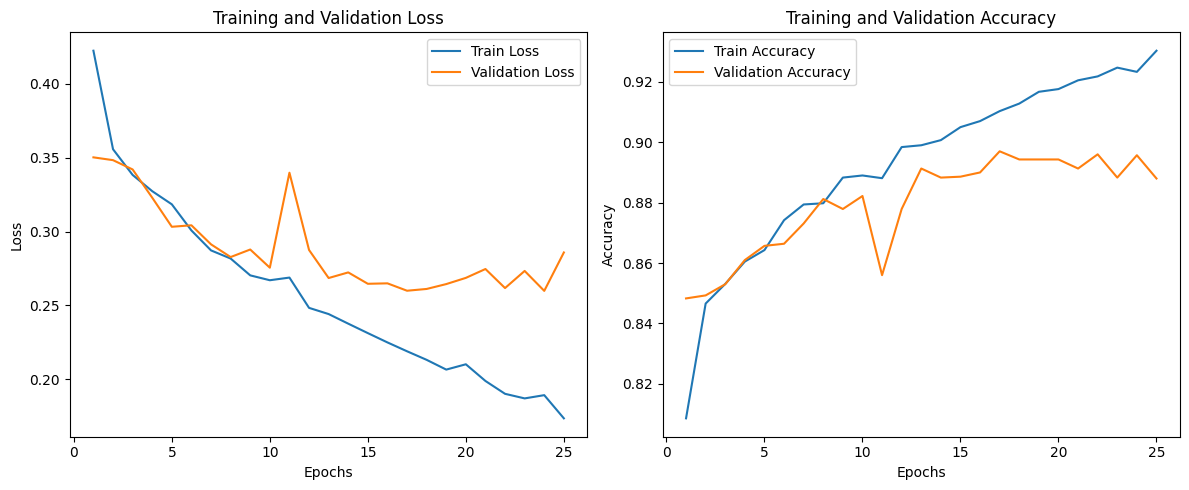

In [ ]:
import matplotlib.pyplot as plt

# Data from your logs
epochs = range(1, 26)  # 25 epochs

# Training and validation loss
train_loss = [
    0.4225, 0.3558, 0.3384, 0.3274, 0.3185, 0.3008, 0.2873, 0.2818, 0.2704, 0.2671,
    0.2689, 0.2484, 0.2442, 0.2377, 0.2313, 0.2250, 0.2190, 0.2132, 0.2066, 0.2102,
    0.1989, 0.1902, 0.1871, 0.1893, 0.1736
]

val_loss = [
    0.3503, 0.3484, 0.3421, 0.3230, 0.3033, 0.3043, 0.2914, 0.2828, 0.2879, 0.2756,
    0.3399, 0.2876, 0.2686, 0.2724, 0.2647, 0.2650, 0.2600, 0.2612, 0.2645, 0.2687,
    0.2747, 0.2618, 0.2734, 0.2599, 0.2859
]

# Training and validation accuracy
train_acc = [
    0.8086, 0.8466, 0.8531, 0.8605, 0.8643, 0.8742, 0.8794, 0.8798, 0.8883, 0.8890,
    0.8881, 0.8984, 0.8990, 0.9007, 0.9050, 0.9070, 0.9103, 0.9128, 0.9167, 0.9176,
    0.9205, 0.9218, 0.9247, 0.9233, 0.9303
]

val_acc = [
    0.8483, 0.8493, 0.8530, 0.8610, 0.8657, 0.8664, 0.8731, 0.8812, 0.8779, 0.8822,
    0.8560, 0.8779, 0.8913, 0.8883, 0.8886, 0.8900, 0.8970, 0.8943, 0.8943, 0.8943,
    0.8913, 0.8960, 0.8883, 0.8957, 0.8880
]

# Plotting Loss Curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()